# NAISS MLB Project 2: Neural Network from Scratch

Instructions unclear, implemented NN in Scratch

## Iteration 1: Literally OOP with typed Python

### Implementation

In [180]:
# Activation functions
from abc import ABC, abstractmethod
import math

class ActivationFunction(ABC):
    @abstractmethod
    def __call__(self, x: float) -> float:
        ...

    @abstractmethod
    def derivative(self, x: float) -> float:
        ...

class Identity(ActivationFunction):
    def __call__(self, x: float) -> float:
        return x

    def derivative(self, x: float) -> float:
        return 1

class Sigmoid(ActivationFunction):
    def __call__(self, x: float) -> float:
        return 1 / (1 + math.exp(-x))

    def derivative(self, x: float) -> float:
        return self(x) * (1 - self(x))
    
class ReLU(ActivationFunction):
    def __call__(self, x: float) -> float:
        return max(0, x)

    def derivative(self, x: float) -> float:
        return 0 if x < 0 else 1

In [181]:
# Weight Initializer
import random

class WeightInitializer:
    def __init__(self, *args, **kwargs):
        ...
    def initialize(self, *args, **kwargs) -> float:
        ...

class RandomWeightInitializer(WeightInitializer):
    min: float
    max: float

    def __init__(self, min: float, max: float):
        self.min = min
        self.max = max
    
    def initialize(self) -> float:
        return random.uniform(self.min, self.max)
    
class ZeroWeightInitializer(WeightInitializer):
    def __init__(self):
        ...
    def initialize(self) -> float:
        return 0
    
class HeWeightInitializer(WeightInitializer):
    fan_in: float

    def __init__(self, fan_in: float):
        if fan_in <= 0:
            raise ValueError("fan_in must be a positive number.")
        self.fan_in = fan_in

    def initialize(self) -> float:
        std_dev = math.sqrt(2.0 / self.fan_in)
        return random.gauss(0, std_dev)
    
class XavierWeightInitializer(WeightInitializer):
    fan_in: float
    fan_out: float

    def __init__(self, fan_in: float, fan_out: float):
        if fan_in <= 0 or fan_out <= 0:
            raise ValueError("fan_in and fan_out must be positive numbers.")
        self.fan_in = fan_in
        self.fan_out = fan_out

    def initialize(self) -> float:
        variance = 2.0 / (self.fan_in + self.fan_out)
        std_dev = math.sqrt(variance)
        return random.gauss(0, std_dev)

In [182]:
# Neural network
import random
from typing import Optional
from tqdm import tqdm

class Hyperparameters:
    learning_rate: float
    epochs: int
    weight_decay: float
    clip_gradient: float
    clip_weight: float
    clip_weight_update: float
    clip_bias: float

    def __init__(self, learning_rate: float, epochs: int, weight_decay: float = 0, clip_gradient: float = 1.0, clip_weight: float = 5.0, clip_weight_update: float = 0.1, clip_bias: float = 5.0):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weight_decay = weight_decay
        self.clip_gradient = clip_gradient
        self.clip_weight = clip_weight
        self.clip_weight_update = clip_weight_update
        self.clip_bias = clip_bias

class Connection:
    from_: 'Neuron'
    to: 'Neuron'
    w: float
    dw: float

    def __init__(self, from_: 'Neuron', to: 'Neuron', weight: float):
        self.from_ = from_
        self.to = to
        self.w = weight
        self.dw = 0


class Neuron:
    a: ActivationFunction
    in_connections: list[Connection]
    out_connections: list[Connection]
    b: float
    d: float
    out: float
    in_sum: float

    def __init__(self, a: ActivationFunction, b: float):
        self.a = a
        self.in_connections = []
        self.out_connections = []
        self.b = b
        self.d = 0
        self.out = 0
        self.in_sum = 0

    def compute_out(self):
        self.in_sum = sum(
            [conn.from_.out * conn.w for conn in self.in_connections]) + self.b
        self.out = self.a(self.in_sum)

    def compute_d(self, hyperparameters: Hyperparameters, target: Optional[float] = None):
        if target is None and self.out_connections:
            self.d = sum([conn.to.d * conn.w for conn in self.out_connections]
                         ) * self.a.derivative(self.in_sum)
        elif target is not None:
            self.d = (target - self.out) * self.a.derivative(self.in_sum)
        else:
            raise ValueError("Target must be specified for output layer")

        # Clip gradients
        self.d = max(min(self.d, hyperparameters.clip_gradient), -hyperparameters.clip_gradient)

    def update_w(self, hyperparameters: Hyperparameters):
        for conn in self.in_connections:
            # With weight decay
            conn.dw = hyperparameters.learning_rate * conn.from_.out * self.d - hyperparameters.weight_decay * conn.w

            # Clip weight update
            conn.dw = max(min(conn.dw, hyperparameters.clip_weight_update), -hyperparameters.clip_weight_update)
            conn.w += conn.dw

            # Clip weight
            conn.w = max(min(conn.w, hyperparameters.clip_weight), -hyperparameters.clip_weight)

        self.b += hyperparameters.learning_rate * self.d
        # Clip bias
        self.b = max(min(self.b, hyperparameters.clip_bias), -hyperparameters.clip_bias)


class Layer:
    neurons: list[Neuron]

    def __init__(self, n: int, a: ActivationFunction, weight_initializer: WeightInitializer):
        self.neurons = [Neuron(a, 0) for _ in range(n)]

    def compute_outs(self):
        for neuron in self.neurons:
            neuron.compute_out()

    def compute_ds(self, hyperparameters: Hyperparameters, targets: Optional[list[float]] = None):
        if targets is None:
            for neuron in self.neurons:
                neuron.compute_d(hyperparameters)
        else:
            for neuron, target in zip(self.neurons, targets):
                neuron.compute_d(hyperparameters, target)

    def update_ws(self, hyperparameters: Hyperparameters):
        for neuron in self.neurons:
            neuron.update_w(hyperparameters)


# Softmax is only used in the output layer and the activation function is multivariate, so can't have the activation function at the neuron level
# This is broken
# class SoftmaxLayer(Layer):
#     def __init__(self, n: int, weight_initializer: WeightInitializer):
#         self.neurons = [Neuron(Identity(), weight_initializer.initialize()) for _ in range(n)]

#     def compute_outs(self):
#         for neuron in self.neurons:
#             neuron.in_sum = sum([conn.from_.out * conn.w for conn in neuron.in_connections]) + neuron.b

#         shift = max([neuron.in_sum for neuron in self.neurons])
#         exps = [math.exp(neuron.in_sum - shift) for neuron in self.neurons]
#         sum_exps = sum(exps)

#         for neuron, exp_val in zip(self.neurons, exps):
#             neuron.out = exp_val / sum_exps

#     def compute_ds(self, hyperparameters: Hyperparameters, targets: Optional[list[float]] = None):
#         if targets is None:
#             raise ValueError("Targets must be specified for softmax layer")
        
#         for neuron, target in zip(self.neurons, targets):
#             neuron.d = neuron.out - target
#             # Clip gradients
#             neuron.d = max(min(neuron.d, hyperparameters.clip_gradient), 
#                             -hyperparameters.clip_gradient)

#     def update_ws(self, hyperparameters: Hyperparameters):
#         for neuron in self.neurons:
#             neuron.update_w(hyperparameters)


class NeuralNetwork:
    layers: list[Layer]
    avg_loss_history: list[float]
    accuracy_history: list[float]

    def __init__(self, layers: list[Layer], random_state: Optional[int] = None):
        self.layers = layers
        self.avg_loss_history = []
        self.accuracy_history = []
        if random_state is not None:
            random.seed(random_state)
        for i, layer in enumerate(self.layers):
            if i > 0:
                for from_neuron in self.layers[i - 1].neurons:
                    for to_neuron in layer.neurons:
                        conn = Connection(
                            from_neuron, to_neuron, random.uniform(-1, 1))
                        from_neuron.out_connections.append(conn)
                        to_neuron.in_connections.append(conn)

    def feed_forward(self, inputs: list[float]) -> list[float]:
        for i, neuron in enumerate(self.layers[0].neurons):
            neuron.out = inputs[i]
        for layer in self.layers[1:]:
            layer.compute_outs()
        return [neuron.out for neuron in self.layers[-1].neurons]

    def back_propagate(self, hyperparameters: Hyperparameters, targets: list[float],):
        self.layers[-1].compute_ds(hyperparameters, targets)

        for layer in reversed(self.layers[:-1]):
            layer.compute_ds(hyperparameters)

    def update_w(self, hyperparameters: Hyperparameters):
        for layer in self.layers[1:]:
            layer.update_ws(hyperparameters)

    def train(self, training_data: list[tuple[list[float], list[float]]], hyperparameters: Hyperparameters):
        for epoch in tqdm(range(hyperparameters.epochs)):
            total_loss = 0
            correct_predictions = 0
            for inputs, targets in training_data:
                outputs = self.feed_forward(inputs)
                self.back_propagate(hyperparameters, targets)
                self.update_w(hyperparameters)
                total_loss += sum((target - output) ** 2 for target, output in zip(targets, outputs)) / len(targets)
                if targets.index(max(targets)) == outputs.index(max(outputs)):
                    correct_predictions += 1
            avg_loss = total_loss / len(training_data)
            accuracy = correct_predictions / len(training_data)
            self.avg_loss_history.append(avg_loss)
            self.accuracy_history.append(accuracy)
            tqdm.write(f"Epoch {epoch + 1}/{hyperparameters.epochs}, Loss: {avg_loss}, Accuracy: {accuracy}")

### Training & Testing

In [208]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

digits = load_digits()

X = digits.data  # type: ignore
y = digits.target  # type: ignore

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

nn = NeuralNetwork([
    Layer(64, ReLU(), HeWeightInitializer(64)),
    Layer(32, ReLU(), HeWeightInitializer(32)),
    Layer(10, Sigmoid(), XavierWeightInitializer(32, 10))
])

training_data = list(zip(X_train.tolist(), [
                     [1.0 if i == target else 0.0 for i in range(10)] for target in y_train]))

nn.train(training_data, Hyperparameters(
    learning_rate=0.02,
    epochs=15,
    weight_decay=0.0001,
    clip_gradient=5.0,
    clip_weight=10.0,
    clip_weight_update=0.5,
    clip_bias=10.0))

probabilities = [nn.feed_forward(x) for x in X_test]
y_pred = [max(enumerate(prob), key=lambda x: x[1])[0]
          for prob in probabilities]

accuracy_score(y_test, y_pred)

  7%|▋         | 1/15 [00:04<00:57,  4.12s/it]

Epoch 1/15, Loss: 0.1458455127769419, Accuracy: 0.35337787676317745


 13%|█▎        | 2/15 [00:08<00:53,  4.13s/it]

Epoch 2/15, Loss: 0.05124822264063953, Accuracy: 0.6555308092056422


 20%|██        | 3/15 [00:12<00:51,  4.25s/it]

Epoch 3/15, Loss: 0.035790004683200836, Accuracy: 0.7587230883444692


 27%|██▋       | 4/15 [00:16<00:46,  4.26s/it]

Epoch 4/15, Loss: 0.028617755859339095, Accuracy: 0.8062360801781737


 33%|███▎      | 5/15 [00:21<00:42,  4.29s/it]

Epoch 5/15, Loss: 0.0242325233852641, Accuracy: 0.8492947290274685


 40%|████      | 6/15 [00:25<00:38,  4.30s/it]

Epoch 6/15, Loss: 0.017807548053429836, Accuracy: 0.9213066072754269


 47%|████▋     | 7/15 [00:29<00:33,  4.25s/it]

Epoch 7/15, Loss: 0.015919498166843654, Accuracy: 0.9354120267260579


 53%|█████▎    | 8/15 [00:33<00:29,  4.22s/it]

Epoch 8/15, Loss: 0.01476541943735936, Accuracy: 0.9480326651818857


 60%|██████    | 9/15 [00:38<00:25,  4.21s/it]

Epoch 9/15, Loss: 0.013774803060177579, Accuracy: 0.9539717891610987


 67%|██████▋   | 10/15 [00:42<00:21,  4.26s/it]

Epoch 10/15, Loss: 0.013092305017660842, Accuracy: 0.961395694135115


 73%|███████▎  | 11/15 [00:46<00:17,  4.30s/it]

Epoch 11/15, Loss: 0.012573960998850317, Accuracy: 0.9651076466221232


 80%|████████  | 12/15 [00:51<00:12,  4.27s/it]

Epoch 12/15, Loss: 0.012272437731507654, Accuracy: 0.9673348181143281


 87%|████████▋ | 13/15 [00:55<00:08,  4.28s/it]

Epoch 13/15, Loss: 0.012038209866967079, Accuracy: 0.9703043801039347


 93%|█████████▎| 14/15 [00:59<00:04,  4.24s/it]

Epoch 14/15, Loss: 0.01182727270281669, Accuracy: 0.9725315515961396


100%|██████████| 15/15 [01:03<00:00,  4.25s/it]

Epoch 15/15, Loss: 0.01164387003873461, Accuracy: 0.9740163325909429


0.9711111111111111

So slow... I didn't profile it but I assume that other than no parallelization, passing stuff around also has a lot of overhead. And I gave up trying to get softmax to work.

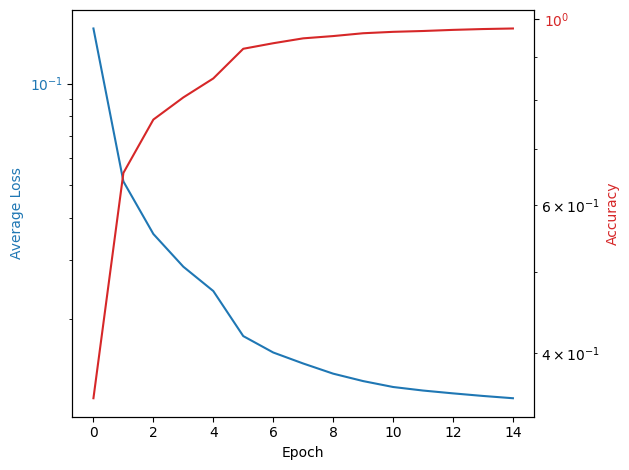

In [209]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss', color=color)
ax1.set_yscale('log')
ax1.plot(nn.avg_loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.set_yscale('log')
ax2.plot(nn.accuracy_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

## Iteration 2: Vectorize with NumPy

### Implementation

In [18]:
# Activation functions
import numpy as np
from abc import ABC, abstractmethod

class ActivationFunction(ABC):
    @abstractmethod
    def __call__(self, x: np.ndarray) -> np.ndarray:
        pass

    @abstractmethod
    def derivative(self, x: np.ndarray) -> np.ndarray:
        pass

class Identity(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return x

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.ones_like(x)

class Sigmoid(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    def derivative(self, x: np.ndarray) -> np.ndarray:
        fx = self(x)
        return fx * (1 - fx)

class ReLU(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return np.maximum(0, x)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return (x > 0).astype(float)
    
class Softmax(ActivationFunction):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        shift_x = x - np.max(x, axis=1, keepdims=True)
        exps = np.exp(shift_x)
        return exps / np.sum(exps, axis=1, keepdims=True)

    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.ones_like(x)

In [4]:
# Weight Initializer

class WeightInitializer:
    def initialize(self, shape: tuple[int, ...]) -> np.ndarray:
        ...

class RandomWeightInitializer(WeightInitializer):
    min: float
    max: float

    def __init__(self, min: float, max: float):
        self.min = min
        self.max_val = max
    
    def initialize(self, shape: tuple[int, ...]) -> np.ndarray:
        return np.random.uniform(self.min, self.max, shape)

class ZeroWeightInitializer(WeightInitializer):
    def initialize(self, shape: tuple[int, ...]) -> np.ndarray:
        return np.zeros(shape)

class HeWeightInitializer(WeightInitializer):
    def initialize(self, shape: tuple[int, ...]) -> np.ndarray:
        fan_in = shape[0]
        std_dev = np.sqrt(2.0 / fan_in)
        return np.random.normal(0, std_dev, shape)

class XavierWeightInitializer(WeightInitializer):
    def initialize(self, shape: tuple[int, ...]) -> np.ndarray:
        fan_in, fan_out = shape
        variance = 2.0 / (fan_in + fan_out)
        std_dev = np.sqrt(variance)
        return np.random.normal(0, std_dev, shape)

In [43]:
# Loss
class LossFunction(ABC):
    @abstractmethod
    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        ...

class MeanSquaredError(LossFunction):
    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return float(np.mean((y_true - y_pred) ** 2))

class CrossEntropy(LossFunction):
    def __call__(self, y_true: np.ndarray, y_pred: np.ndarray) -> float:
        return -np.sum(y_true * np.log(y_pred))

In [65]:
# Neural network
from typing import Optional
from tqdm import tqdm
import random

class Hyperparameters:
    def __init__(
        self,
        learning_rate: float,
        epochs: int,
        batch_size: int = 32,
        weight_decay: float = 0,
        clip_gradient: float = 1.0,
        clip_weight: float = 5.0,
        clip_weight_update: float = 0.1,
        clip_bias: float = 5.0
    ):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.clip_gradient = clip_gradient
        self.clip_weight = clip_weight
        self.clip_weight_update = clip_weight_update
        self.clip_bias = clip_bias

class Layer:
    size: int
    a: ActivationFunction
    w: np.ndarray
    b: np.ndarray
    z: np.ndarray
    w_updates: np.ndarray
    b_updates: np.ndarray
    out: np.ndarray

    def __init__(self, size: int, a: ActivationFunction):
        self.size = size
        self.a = a
        self.w = np.empty((0, 0))
        self.b = np.empty(0)
        self.out = np.empty(0)
        self.z = np.empty(0)  # Pre-activation values
        self.w_updates = np.empty((0, 0))
        self.b_updates = np.empty(0)

    def initialize(self, input_size: int, weight_initializer: WeightInitializer):
        self.w = weight_initializer.initialize((input_size, self.size))
        self.b = np.zeros(self.size)

class NeuralNetwork:
    def __init__(
        self,
        layer_configs: list[tuple[int, ActivationFunction, WeightInitializer]],
        random_state: Optional[int] = None
    ):
        if random_state is not None:
            random.seed(random_state)
            np.random.seed(random_state)
            
        self.layers = []
        for i, (size, activation, weight_initializer) in enumerate(layer_configs):
            layer = Layer(size, activation)
            if i > 0:
                layer.initialize(layer_configs[i-1][0], weight_initializer)
            self.layers.append(layer)
                
        self.avg_loss_history = []
        self.accuracy_history = []

    def feed_forward(self, X: np.ndarray) -> np.ndarray:
        current_input = X
        self.layers[0].out = current_input

        for i in range(1, len(self.layers)):
            layer = self.layers[i]
            layer.z = np.dot(current_input, layer.w) + layer.b
            layer.out = layer.a(layer.z)
            current_input = layer.out

        return self.layers[-1].out

    def back_propagate(self, X: np.ndarray, y: np.ndarray, hyperparameters: Hyperparameters):
        batch_size = X.shape[0]
        
        # Output layer
        output_layer = self.layers[-1]
        delta = (output_layer.out - y) * output_layer.a.derivative(output_layer.z)
        # Clip gradient
        delta = np.clip(delta, -hyperparameters.clip_gradient, hyperparameters.clip_gradient)

        for i in range(len(self.layers) - 1, 0, -1):
            layer = self.layers[i]
            prev_layer = self.layers[i-1]

            # Weight decay
            layer.w_updates = (
                np.dot(prev_layer.out.T, delta) / batch_size - 
                hyperparameters.weight_decay * layer.w
            )
            layer.b_updates = np.mean(delta, axis=0)

            # Clip weight updates
            layer.w_updates = np.clip(
                layer.w_updates, 
                -hyperparameters.clip_weight_update,
                hyperparameters.clip_weight_update
            )
            
            if i > 1:
                delta = (np.dot(delta, layer.w.T) * 
                        prev_layer.a.derivative(prev_layer.z))
                # Clip delta
                delta = np.clip(delta, -hyperparameters.clip_gradient, hyperparameters.clip_gradient)

    def update_w(self, hyperparameters: Hyperparameters):
        for layer in self.layers[1:]:
            layer.w -= hyperparameters.learning_rate * layer.w_updates
            # Clip w
            layer.w = np.clip(
                layer.w, 
                -hyperparameters.clip_weight,
                hyperparameters.clip_weight
            )
            
            layer.b -= hyperparameters.learning_rate * layer.b_updates
            # Clip b
            layer.b = np.clip(
                layer.b,
                -hyperparameters.clip_bias,
                hyperparameters.clip_bias
            )

    def train(
        self,
        X: np.ndarray,
        y: np.ndarray,
        hyperparameters: Hyperparameters,
        loss_function: LossFunction
    ):
        n_samples = X.shape[0]
        n_batches = (n_samples + hyperparameters.batch_size - 1) // hyperparameters.batch_size

        for epoch in tqdm(range(hyperparameters.epochs)):
            # Shuffle data
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            total_loss = 0
            correct_predictions = 0

            for i in range(n_batches):
                start_idx = i * hyperparameters.batch_size
                end_idx = min((i + 1) * hyperparameters.batch_size, n_samples)
                
                X_batch = X_shuffled[start_idx:end_idx]
                y_batch = y_shuffled[start_idx:end_idx]

                outputs = self.feed_forward(X_batch)
                self.back_propagate(X_batch, y_batch, hyperparameters)
                self.update_w(hyperparameters)

                # Calculate metrics
                batch_loss = loss_function(y_batch, outputs)
                total_loss += batch_loss * (end_idx - start_idx)
                
                predicted_classes = np.argmax(outputs, axis=1)
                true_classes = np.argmax(y_batch, axis=1)
                correct_predictions += np.sum(predicted_classes == true_classes)

            avg_loss = total_loss / n_samples
            accuracy = correct_predictions / n_samples
            self.avg_loss_history.append(avg_loss)
            self.accuracy_history.append(accuracy)
            
            # tqdm.write(
            #     f"Epoch {epoch + 1}/{hyperparameters.epochs}, Loss: {avg_loss:}, Accuracy: {accuracy}"
            # )

### Training & Testing

In [82]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

digits = load_digits()

X = digits.data  # type: ignore
y = digits.target  # type: ignore

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

nn = NeuralNetwork([
    (64, ReLU(), HeWeightInitializer()),
    (48, ReLU(), HeWeightInitializer()),
    (32, ReLU(), HeWeightInitializer()),
    (16, ReLU(), HeWeightInitializer()),
    (10, Softmax(), XavierWeightInitializer())
], random_state=42)

nn.train(
    X_train,
    np.array([[1.0 if i == target else 0.0 for i in range(10)] for target in y_train]),
    Hyperparameters(
    learning_rate=0.05,
    epochs=40,
    batch_size=32,
    weight_decay=0.0001,
    clip_gradient=5.0,
    clip_weight=10.0,
    clip_weight_update=0.5,
    clip_bias=10.0),
    CrossEntropy()
)

probabilities = nn.feed_forward(X_test)
y_pred = np.argmax(probabilities, axis=1)

accuracy_score(y_test, y_pred)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [00:00<00:00, 64.23it/s]


0.9777777777777777

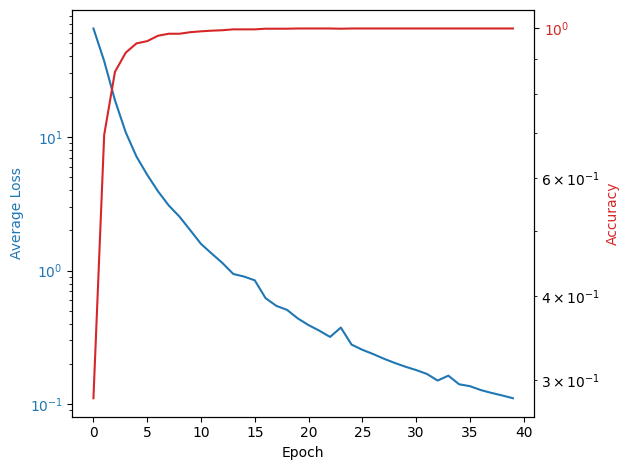

In [83]:
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 100
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss', color=color)
ax1.set_yscale('log')
ax1.plot(nn.avg_loss_history, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.set_yscale('log')
ax2.plot(nn.accuracy_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()

Good.